In [29]:
import geopandas as gpd
import osmnx as ox
import folium
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import box
import city2graph as c2g
from matplotlib.lines import Line2D

<Axes: >

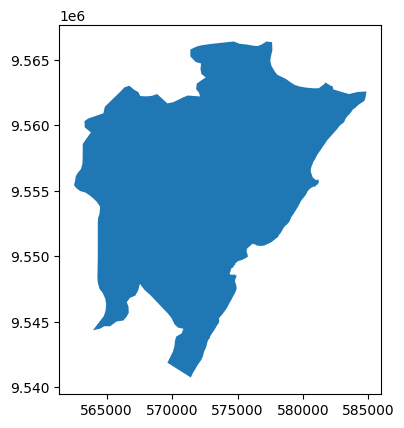

In [30]:
city_name = 'Mombasa'
admin = ox.geocode_to_gdf(city_name).to_crs(epsg=32737)
admin.plot()

In [40]:
# geting the network and convert to gdf
segments_gdf = ox.graph_to_gdfs(ox.graph_from_place(city_name, network_type='drive'))[1].to_crs(epsg=32737)
len(segments_gdf)
# segments_gdf.crs

18149

In [41]:
# defining our POIs
poi_features = {
    'education': {'amenity': ['school', 'university']},
    'daily_needs': {'shop': ['supermarket', 'convenience']},
    'social_life': {'amenity': ['restaurant', 'cafe']},
    'health_services': {'amenity': ['hospital', 'clinic', 'pharmacy']}
}

poi_layers = {}
for label, query in poi_features.items():
    try:
        poi = ox.features_from_place(city_name, tags=query).to_crs(epsg=32737)  
        poi_layers[label] = poi[poi.geometry.type == 'Point']
        print(label, len(poi))
    except Exception as e:
        print(f"{label}: failed → {e}")
# for label, gdf in poi_layers.items():
#     print(label, gdf.crs)    
    

education 118
daily_needs 37
social_life 122
health_services 49


In [42]:
# getting the waxman network graph
waxman_graphs = {}
radius = 1000
for label, gdf in poi_layers.items():
    if len(gdf)>1:
        nodes, edges = c2g.waxman_graph(
            gdf,
            distance_metric = 'network',
            r0=radius,
            beta=0.5,
            network_gdf=segments_gdf
        )
        # extract only the paths
        waxman_graphs[label] = edges
len(waxman_graphs) 
# for label, edges in waxman_graphs.items():
#     print(edges.crs)



4

In [43]:
layer_colors = {
    'education': '#00e5ff',
    'daily_needs': '#ffea00',
    'social_life': '#ff4081',
    'health_services': '#76ff03' 
}

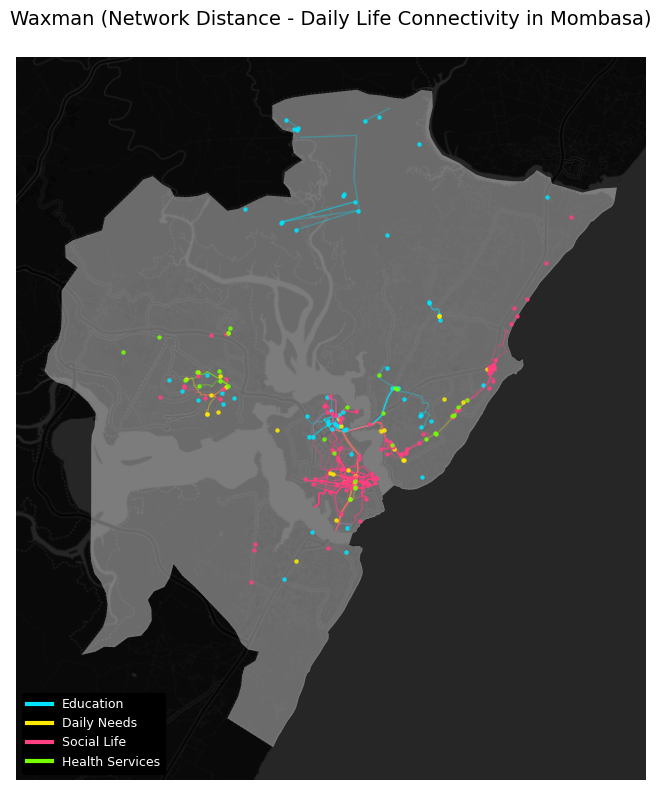

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
admin.plot(ax=ax, color='white', linewidth=1.0, alpha=0.4, zorder=5)

for label, edges in waxman_graphs.items():
    # go through each geometry
    for _, row in edges.iterrows():
        # extract the coordinates and plot
        x, y = row.geometry.xy
        ax.plot(x, y, color=layer_colors[label], linewidth=1.0, alpha=0.3, label=label, zorder=6)

for label, pois in poi_layers.items():
    pois.to_crs(32737).plot(ax=ax, markersize=5, color=layer_colors[label], alpha=0.8, zorder=7)

    # Legend
    legend_elements = [Line2D([0], [0], color=color, lw=3, label=label.replace("_"," ").title()) for label, color in layer_colors.items()]

    legend = ax.legend(
        handles=legend_elements,
        loc='lower left',
        bbox_to_anchor=(0, 0),
        frameon=True,
        framealpha=1,
        facecolor='black',
        edgecolor='black',
        fontsize=9,
        labelcolor='white',
        #title= "  " + city_name.split(",")[0],
        #title_fontproperties={'weight':'bold', 'size':15}
    )
    legend.get_title().set_color('white')


ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels, crs=32737, zoom=12, attribution=False)

ax.set_axis_off()
ax.set_title('Waxman (Network Distance - Daily Life Connectivity in Mombasa)', fontsize=14, color='black', pad=12)
plt.tight_layout()
plt.show()

In [54]:
# defining our working scopes for multiple cities
cities = ['Mombasa, Kenya', 'Nakuru, Kenya', 'Kisumu, Kenya', 'Nairobi, Kenya']

radius = 2000

layer_colors = {
    'education': '#00e5ff',
    'daily_needs': '#ffea00',
    'social_life': '#ff4081',
    'health_services': '#76ff03' 
}

poi_queries = {
    'education': {'amenity': ['school', 'university']},
    'daily_needs': {'shop': ['supermarket', 'convenience']},
    'social_life': {'amenity': ['restaurant']},
    'health_services': {'amenity': ['hospital', 'clinic', 'pharmacy']}
}

# check to ensure each city has a poi feature
poi_counts = {}

for city_name in cities:
    print(f"\n{city_name}")
    poi_counts[city_name] = {}

    for label, query in poi_queries.items():
        try:
            poi = ox.features_from_place(city_name, query).to_crs(32737)
            poi = poi[poi.geometry.type == "Point"]
            count = len(poi)
           
            poi_counts[city_name][label] = count
            print(f"  {label}: {count}")

        except Exception as e:
            poi_counts[city_name][label] = 0
            print(f"  {label}: failed → {e}")
    


Mombasa, Kenya
  education: 61
  daily_needs: 34
  social_life: 83
  health_services: 29

Nakuru, Kenya
  education: 18
  daily_needs: 13
  social_life: 30
  health_services: 10

Kisumu, Kenya
  education: 99
  daily_needs: 21
  social_life: 32
  health_services: 110

Nairobi, Kenya
  education: 1918
  daily_needs: 320
  social_life: 906
  health_services: 965



 Processing Mombasa, Kenya
education: 61 points
daily_needs: 34 points
social_life: 83 points
health_services: 29 points
education: 61 points, 103 edges
daily_needs: 34 points, 39 edges
social_life: 83 points, 311 edges
health_services: 29 points, 29 edges


/tmp/ipykernel_7028/2989834384.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_shape = admin.geometry.unary_union


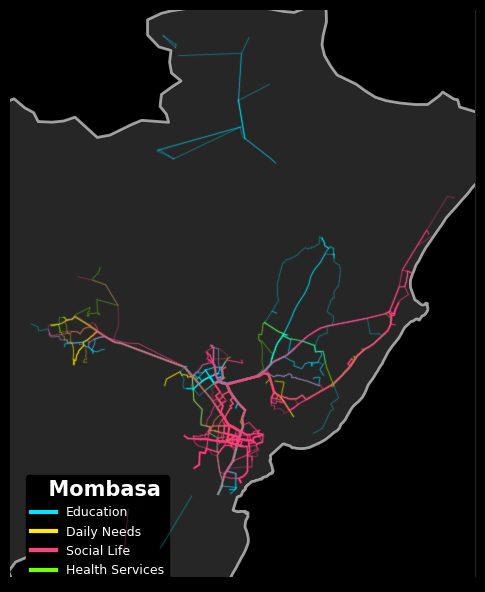


 Processing Nakuru, Kenya
education: 18 points
daily_needs: 13 points
social_life: 30 points
health_services: 10 points
education: 18 points, 17 edges
daily_needs: 13 points, 13 edges
social_life: 30 points, 42 edges
health_services: 10 points, 13 edges


/tmp/ipykernel_7028/2989834384.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_shape = admin.geometry.unary_union


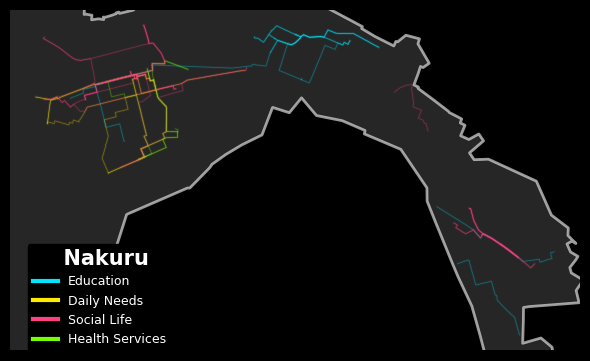


 Processing Kisumu, Kenya
education: 99 points
daily_needs: 21 points
social_life: 32 points
health_services: 110 points
education: 99 points, 537 edges
daily_needs: 21 points, 28 edges
social_life: 32 points, 70 edges
health_services: 110 points, 801 edges


/tmp/ipykernel_7028/2989834384.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_shape = admin.geometry.unary_union


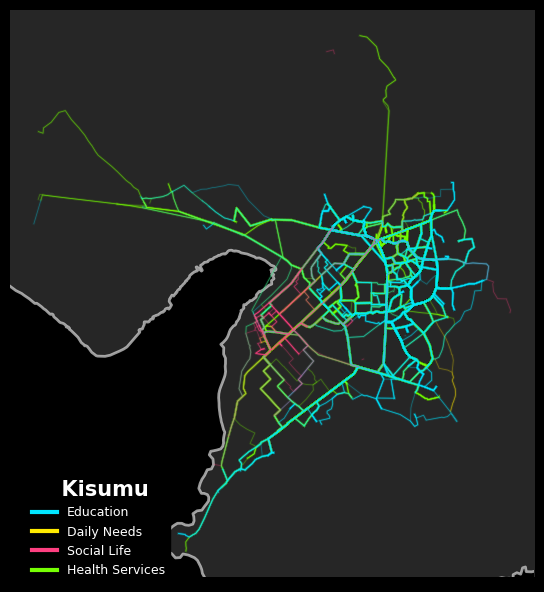


 Processing Nairobi, Kenya
education: 1918 points
daily_needs: 320 points
social_life: 906 points
health_services: 965 points


In [ ]:
for city_name in cities:
    print(f'\n Processing {city_name}')

    # Convert city boundary to gdf and project
    admin = ox.geocode_to_gdf(city_name).to_crs(32737)

    # get the path network
    G = ox.graph_from_place(city_name, network_type='drive')
    segments_gdf = ox.graph_to_gdfs(G)[1].to_crs(32737)

    # getting the POIs
    poi_layers = {}
    for label, query in poi_queries.items():
        poi = ox.features_from_place(city_name, query).to_crs(32737)
        poi_layers[label] = poi[poi.geometry.type == 'Point']
        print(f'{label}: {len(poi_layers[label])} points')

    # Build Waxman Graphs
    wax_graphs = {}
    for label, pois in poi_layers.items():
        if len(pois) > 1:
            nodes, edges = c2g.waxman_graph(
                pois,
                distance_metric = 'network',
                r0 = radius,
                beta = 0.5,
                network_gdf = segments_gdf
            )
            wax_graphs[label] = edges
            print(f'{label}: {len(poi_layers[label])} points, {len(edges)} edges')
        else:
            wax_graphs[label] = gpd.GeoDataFrame()

    # # Plot results
    # plot_city_connectivity(city_name, admin, poi_layers, wax_graphs, radius)

In [ ]:
def plot_city_connectivity(city_name, admin, poi_layers, wax_graphs, radius):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.patch.set_facecolor('black')
    
    admin.boundary.plot(ax=ax, color='white', linewidth=2.0, alpha=0.6, zorder=5)

    for label in ['daily_needs', 'health_services', 'education', 'social_life']:
        edges = wax_graphs.get(label)
        if edges is None or edges.empty:
            continue
        color = layer_colors[label]
        for _, row in edges.iterrows():
            x, y = row.geometry.xy
            ax.plot(x, y, color=color, linewidth=2.0, alpha=0.05, zorder=6)
            ax.plot(x, y, color=color, linewidth=0.6, alpha=0.3, zorder=7)
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels, crs=3857, zoom=11, attribution=False)
    
    ax.set_axis_off()

    all_bounds = [gdf.total_bounds for gdf in wax_graphs.values() if not gdf.empty]

    minx = min(b[0] for b in all_bounds)
    miny = min(b[1] for b in all_bounds)
    maxx = max(b[2] for b in all_bounds)
    maxy = max(b[3] for b in all_bounds)

    buffer_x = (maxx - minx) * 0.05
    buffer_y = (maxy - miny) * 0.05

    zoom_minx = minx - buffer_x
    zoom_maxx = maxx + buffer_x
    zoom_miny = miny - buffer_y
    zoom_maxy = maxy + buffer_y

    ax.set_xlim(zoom_minx, zoom_maxx)
    ax.set_ylim(zoom_miny, zoom_maxy)

    outer_box = box(
        zoom_minx - buffer_x, zoom_miny - buffer_y,
        zoom_maxx + buffer_x, zoom_maxy + buffer_y
    )

    city_shape = admin.geometry.unary_union
    mask_geom = outer_box.difference(city_shape)
    gpd.GeoSeries([mask_geom], crs=admin.crs).plot(
        ax=ax, color='black', zorder=4
    )

    # Legend
    legend_elements = [Line2D([0], [0], color=color, lw=3, label=label.replace("_"," ").title()) for label, color in layer_colors.items()]

    legend = ax.legend(
        handles=legend_elements,
        loc='lower left',
        bbox_to_anchor=(0.02, -0.02),
        frameon=True,
        framealpha=1,
        facecolor='black',
        edgecolor='black',
        fontsize=9,
        labelcolor='white',
        title= "  " + city_name.split(",")[0],
        title_fontproperties={'weight':'bold', 'size':15}
    )
    legend.get_title().set_color('white')
    
    plt.tight_layout()
    plt.show()

plot_city_connectivity(city_name, admin, poi_layers, wax_graphs, radius)